In [1]:
__author__ = "Lisette Espin"
__copyright__ = "Copyright 2019, GESIS / USC-ISI"
__credits__ = ["Lisette Espin-Noboa", 
               "Fariba Karimi",                
               "Claudia Wagner",
               "Markus Strohmaier"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Lisette Espin"
__email__ = "lisette.espin@gesis.org"
__status__ = "Development"

In [2]:
import os
import ast
import operator
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from joblib import Parallel, delayed

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../code')

from org.gesis.libs import io
from org.gesis.libs import viz
from org.gesis.libs import utils
from org.gesis.libs import ranking
from org.gesis.libs.utils import printf
from org.gesis.model.graph import DirectedGraph
from org.gesis.model.graph import get_homophily
from org.gesis.model.DHBA import estimate_homophily_empirical

<h1>Model Fitting</h1>

In [4]:
DATASETS = ['aps','github','pokec','wikipedia'] #'twitter'
MODELS = ['DH','DBA','DHBA'] #'DT', 'DHTBA'
ROOT = '../../data/'
OUTPUT = "../../results-batch/"
PLOTS = '../../plots/'

In [5]:
df_summary = None                  # datasets summary properties
df_rank_empirical = None           # fraction of minorities in top-k rank (empirical networks)
df_rank_synthetic = None           # fraction of minorities in top-k rank (synthetic networks)

<h2>Datasets</h2>

In [6]:
fn = os.path.join(OUTPUT, 'summary_datasets.csv')
df_summary = io.read_csv(fn)
df_summary

,dataset,N,cc,class,m,M,fm,E,Emm,EMM,...,EMm,density,gammaM,kminM,gammam,kminm,hMM,hmm,triadsratio,triadspdf
0,APS,1853,173,pacs,05.20.-y,05.30.-d,0.38,3638,0.294,0.650,...,0.029,0.00106,2.880254,4.0,5.020234,5.0,0.95,0.93,7.741234e-07,"[0.0, 0.2602935911206588, 0.0, 0.6942355889724..."
1,Github,296612,6965,gender,female,male,0.06,1723930,0.005,0.899,...,0.051,0.00002,2.847932,60.0,2.661940,21.0,0.55,0.61,2.551588e-10,"[0.00012062479001814398, 0.0006425589775966516..."
2,Pokec,1632636,1,gender,1,0,0.49,30622117,0.195,0.250,...,0.248,0.00001,4.506221,131.0,3.850320,109.0,0.51,0.38,2.853004e-11,"[0.043744452862550076, 0.0685444396945499, 0.0..."
3,Wikipedia,3159,66,gender,female,male,0.15,14890,0.030,0.785,...,0.078,0.00149,3.647207,17.0,2.435874,5.0,0.67,0.58,1.416910e-06,"[0.0009691331104327179, 0.0026166593981683385,..."


<h2>Ranking Empirical</h2>

In [7]:
df_rank_empirical = ranking.rank_empirical(ROOT, df_summary.dataset.unique(), OUTPUT)
df_rank_empirical.head()        

,kind,metric,dataset,rank,fmt
0,empirical,pagerank,APS,5.0,0.500000
1,empirical,pagerank,APS,10.0,0.406250
2,empirical,pagerank,APS,20.0,0.421053
3,empirical,pagerank,APS,30.0,0.377551
4,empirical,pagerank,APS,40.0,0.357143


<h2>Ranking Synthetic Fit</h2>

In [8]:
df_rank_synthetic = ranking.rank_fit(df_summary.dataset.unique(), OUTPUT)
df_rank_synthetic.head()   

,kind,metric,dataset,rank,fmt
0,DHBA,pagerank,APS,5.0,0.272727
1,DHBA,pagerank,APS,10.0,0.279070
2,DHBA,pagerank,APS,20.0,0.372093
3,DHBA,pagerank,APS,30.0,0.379845
4,DHBA,pagerank,APS,40.0,0.374269


<h2>Plotting Ranks</h2>

In [9]:
df_rank = df_rank_empirical.copy()
df_rank = df_rank.append(df_rank_synthetic.copy())
df_rank.sample(5)

,kind,metric,dataset,rank,fmt
1516,DBA,wtf,Github,90.0,0.00
2233,DHBA,wtf,Pokec,5.0,0.40
2254,DHBA,pagerank,Pokec,100.0,0.49
3235,DHBA,pagerank,Wikipedia,10.0,0.05
1138,DHBA,circle_of_trust,Github,50.0,0.00


<h3>Empirical vs Synthetic</h3>

<p style="color:red">Github and Pokec do not have circle_of_trust and wtf ranking for empirical yet</p>

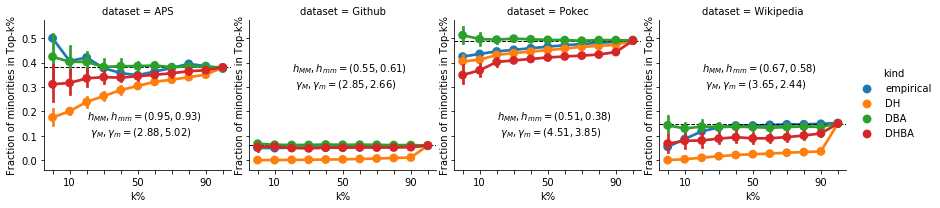

In [10]:
viz.plot_model_fit(df_rank, df_summary, metric='pagerank', fn=None)

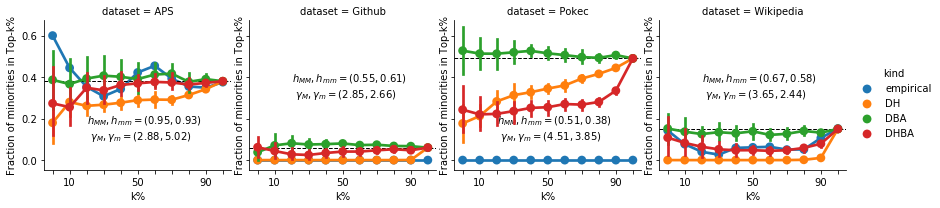

In [11]:
viz.plot_model_fit(df_rank, df_summary, metric='circle_of_trust', fn=None)

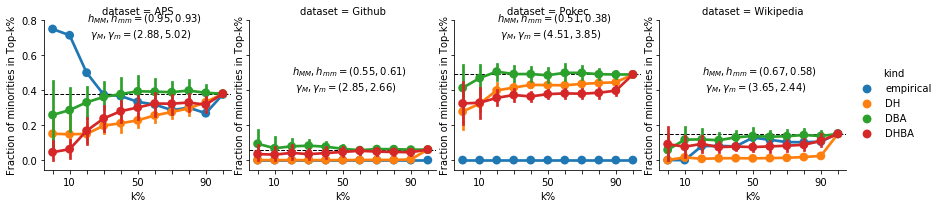

In [12]:
viz.plot_model_fit(df_rank, df_summary, metric='wtf', fn=None)

<h1>Hypothesis Tests</h1>

<h2>Jensen Shannon</h2>

<p style="color:blue">The ranking curve (model) closest to the empirical fraction of minorities (using Shannon distance)</p>

In [13]:
df_js = ranking.JS_divergence_fit(df_rank)

In [14]:
tmp_min = df_js.groupby(['dataset','metric']).distance.min().reset_index()
tmp_min = tmp_min.set_index(['dataset','metric','distance'])
tmp_best = df_js.set_index(['dataset','metric','distance'])
tmp_best = tmp_best.join(other=tmp_min, on=['dataset','metric','distance'],how='right')
tmp_best.pivot_table(index='dataset', columns='metric', values='model', aggfunc='first',fill_value="-")

metric,circle_of_trust,pagerank,wtf
dataset,,,
APS,DBA,DBA,DBA
Github,-,DHBA,-
Pokec,-,DH,-
Wikipedia,DHBA,DHBA,DBA
